In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("new.csv")
data = data[["date", "time", "price"]]

In [3]:
import pickle
copy = lambda obj: pickle.loads(pickle.dumps(obj))

In [4]:
class Result:
    def __init__(self, balance):
        self.balance = balance
        self.volume = 0
        self.prevPosIndex = -1
        self.openIndex = 0
        self.closeIndex = 0

    def __gt__(self, other): 
        return self.balance > other.balance  

In [5]:
def relax(main, other): return main if main > other else other

In [6]:
class Investments:
    def __init__(self, data, transacMax, startBalance):
        self.data = data.copy()
        self.transacMax = transacMax
        self.startBalance = startBalance

    def fit(self):
        # Для подсчета используется динамика dp[i][flg]
        dp = np.full((self.transacMax + 1, 2), Result(0))
        # с восстановлением ответа. dp[i][flg] - макс результат, если мы еще можем совершить i сделок,
        # flg = 1, если при этом мы находимся в позиции, flg = 0 иначе
        dp[self.transacMax][0] = Result(self.startBalance)

        prevPrice = self.data["price"][0]
        self.positions = []

        for index, price in enumerate(self.data["price"]):
            for j in range(self.transacMax + 1):
                dp[j][1].balance += dp[j][1].volume * (price - prevPrice)

            for j in range(1, self.transacMax + 1):
                pos = copy(dp[j][1])
                pos.closeIndex = index
                self.positions.append(copy(pos))
                pos.prevPosIndex = len(self.positions) - 1
                dp[j - 1][0] = copy(relax(dp[j - 1][0], pos))

            for j in range(1, self.transacMax + 1):
                pos = copy(dp[j][0])
                pos.volume = dp[j][0].balance // price
                pos.openIndex = index
                dp[j][1] = copy(relax(dp[j][1], pos))

            prevPrice = price

        self.indexesOfPos = [dp[0][0].prevPosIndex]
        for j in range(self.transacMax - 1):  # Восстановление ответа
            self.indexesOfPos.append(
                self.positions[self.indexesOfPos[-1]].prevPosIndex)

    def show(self, pictureName=None):
        fig, ax = plt.subplots(figsize=(32, 16))
        ax.plot(self.data["price"], linewidth=1)

        for indexOfPos in self.indexesOfPos:
            openIndex = self.positions[indexOfPos].openIndex
            closeIndex = self.positions[indexOfPos].closeIndex
            ax.plot([openIndex, closeIndex], [self.data["price"][
                    openIndex], self.data["price"][closeIndex]], linewidth=6)

        ax.set(xlabel='time', ylabel='price')
        ax.grid()
        if not(pictureName is None):
            fig.savefig(pictureName)
        plt.show()

    def getInfo(self, fileNameCSV=None):
        for number, indexOfPos in enumerate(self.indexesOfPos[::-1]):
            openIndex = self.positions[indexOfPos].openIndex
            closeIndex = self.positions[indexOfPos].closeIndex
            cInfo = self.data[openIndex + 1: closeIndex + 1].copy()
            cInfo["price"] = np.array(
                cInfo["price"]) - np.array(self.data[openIndex:closeIndex]["price"])
            cInfo.index = range(closeIndex - openIndex)
            cInfo["date_change"] = cInfo["date"]
            cInfo["time_change"] = cInfo["time"]
            cInfo["price_change"] = cInfo["price"]
            cInfo.drop(["price", "date", "time"], inplace=True, axis=1)
            mainInfo = pd.DataFrame(
                {
                    'date_open': [
                        self.data["date"][openIndex]], 'time_open': [
                        self.data["time"][openIndex]], 'price_open': [
                        self.data["price"][openIndex]], 'time_close': [
                        self.data["date"][closeIndex]], 'date_close': [
                            self.data["date"][closeIndex]], 'price_close': [
                                self.data["price"][closeIndex]], 'volume': [
                                    self.positions[indexOfPos].volume]})
            df = cInfo.join(mainInfo)
            if not(fileNameCSV is None):
                df.to_csv(str(number) + '_' + fileNameCSV)

            print(
                "Позиция № ",
                number + 1,
                " была открыта ",
                self.data["date"][openIndex],
                " в ",
                self.data["time"][openIndex],
                " по цене ",
                self.data["price"][openIndex],
                " объемом ",
                self.positions[indexOfPos].volume)
            print(
                "Позиция № ",
                number + 1,
                " была закрыта ",
                self.data["date"][closeIndex],
                " в ",
                self.data["time"][closeIndex],
                " по цене ",
                self.data["price"][closeIndex])
            print("Баланс ", self.positions[indexOfPos].balance)

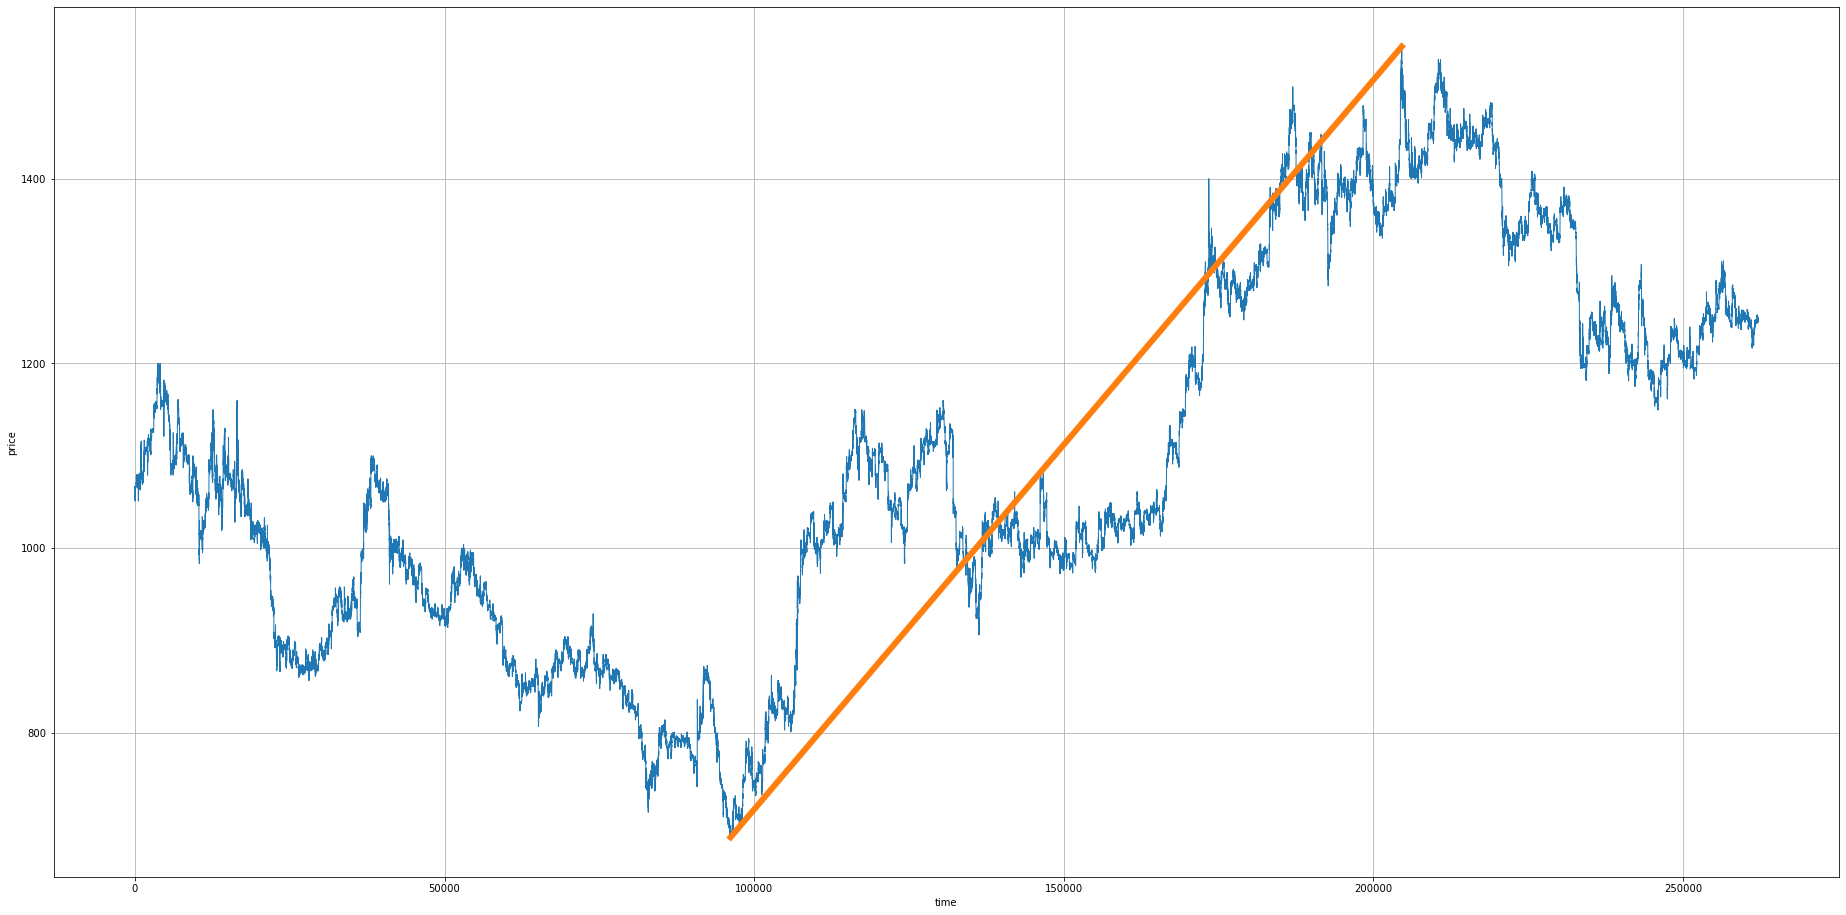

Позиция №  1  была открыта  20150929  в  113500  по цене  687.0  объемом  14.0
Позиция №  1  была закрыта  20160728  в  163400  по цене  1543.0
Баланс  21983.999999999964


In [7]:
model = Investments(data, 1, 10000) # 1 транзакция, депозит 10000
model.fit()
model.show("chart_YDX_1.png") # Можно сохранить график в файл при желании
model.getInfo()

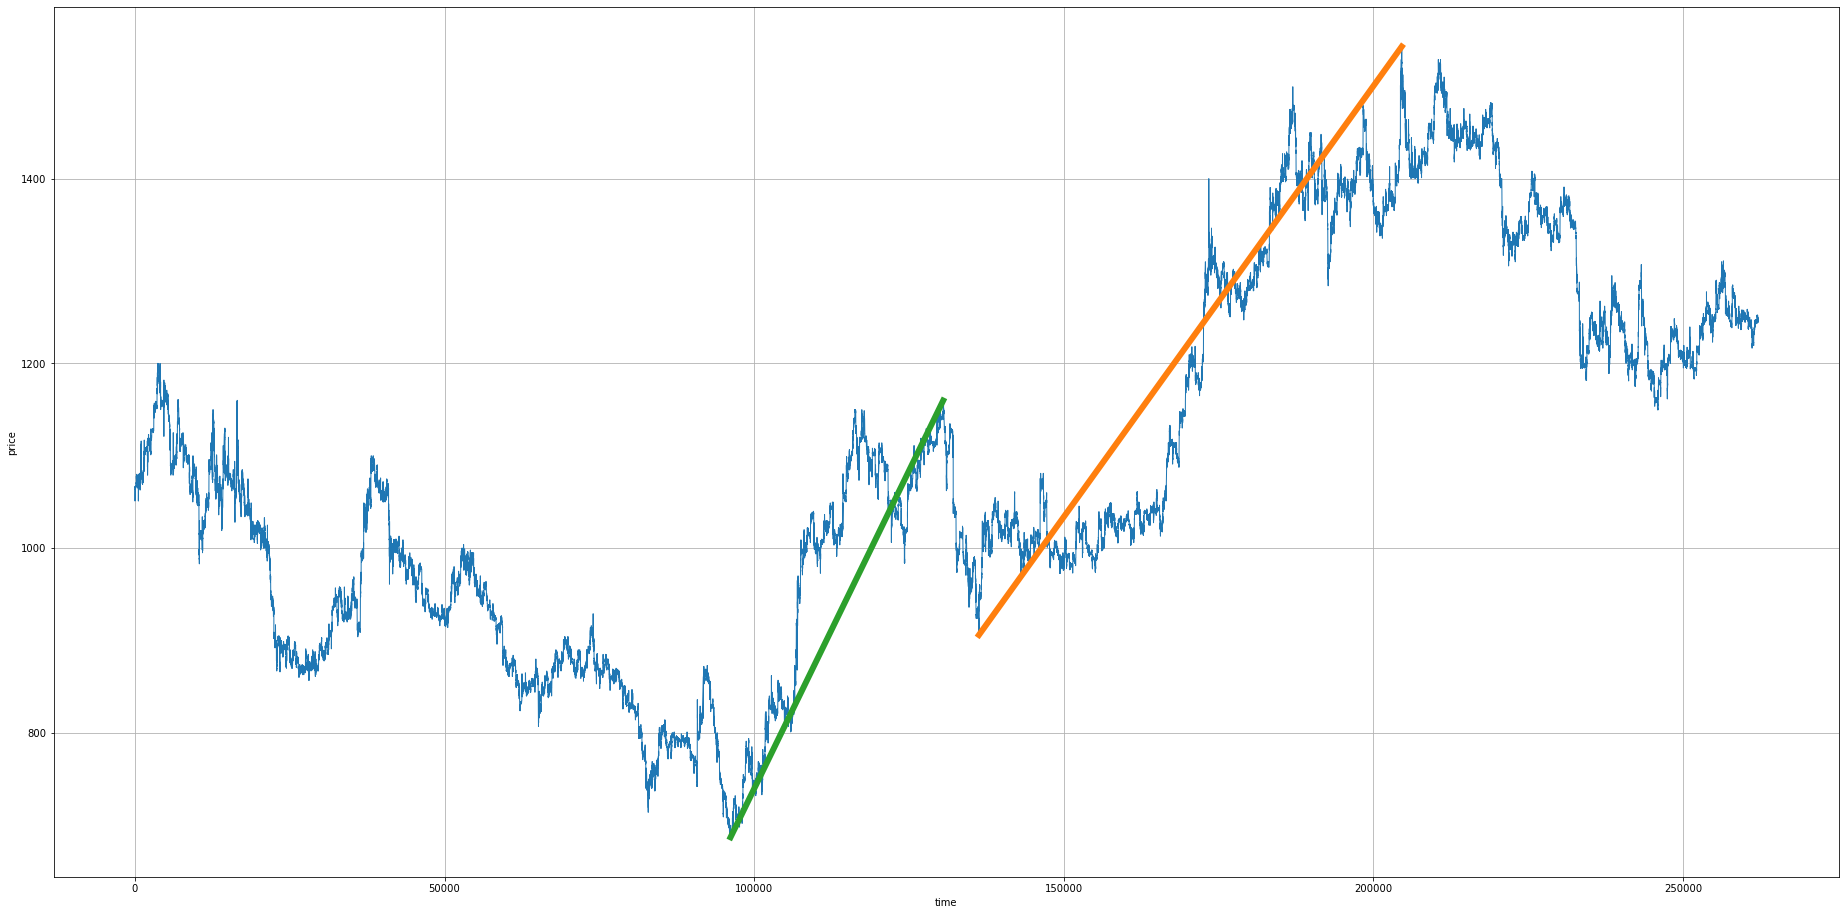

In [8]:
model = Investments(data, 2, 10000) # 2 транзакции, депозит 10000
model.fit()
model.show() 

In [9]:
model.getInfo("YDX_2.csv") # Можно вывести информацию о сделках и сохранить её при желании

Позиция №  1  была открыта  20150929  в  113500  по цене  687.0  объемом  14.0
Позиция №  1  была закрыта  20151230  в  175300  по цене  1159.8
Баланс  16619.19999999996
Позиция №  2  была открыта  20160120  в  181400  по цене  906.0  объемом  18.0
Позиция №  2  была закрыта  20160728  в  163400  по цене  1543.0
Баланс  28085.200000000008


In [10]:
#Более подробная информация хранится в файлах
file0 = pd.read_csv("0_YDX_2.csv")
file0

,Unnamed: 0,date_change,time_change,price_change,date_open,time_open,price_open,time_close,date_close,price_close,volume
0,0,20150929,113600,2.0,20150929.0,113500.0,687.0,20151230.0,20151230.0,1159.8,14.0
1,1,20150929,113700,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,20150929,113800,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,20150929,113900,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,20150929,114000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
34329,34329,20151230,174900,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34330,34330,20151230,175000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34331,34331,20151230,175100,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34332,34332,20151230,175200,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
file1 = pd.read_csv("1_YDX_2.csv")
file1

,Unnamed: 0,date_change,time_change,price_change,date_open,time_open,price_open,time_close,date_close,price_close,volume
0,0,20160120,181500,3.3,20160120.0,181400.0,906.0,20160728.0,20160728.0,1543.0,18.0
1,1,20160120,181600,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,20160120,181700,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,20160120,181800,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,20160120,181900,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
68266,68266,20160728,163000,-20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68267,68267,20160728,163100,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68268,68268,20160728,163200,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68269,68269,20160728,163300,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


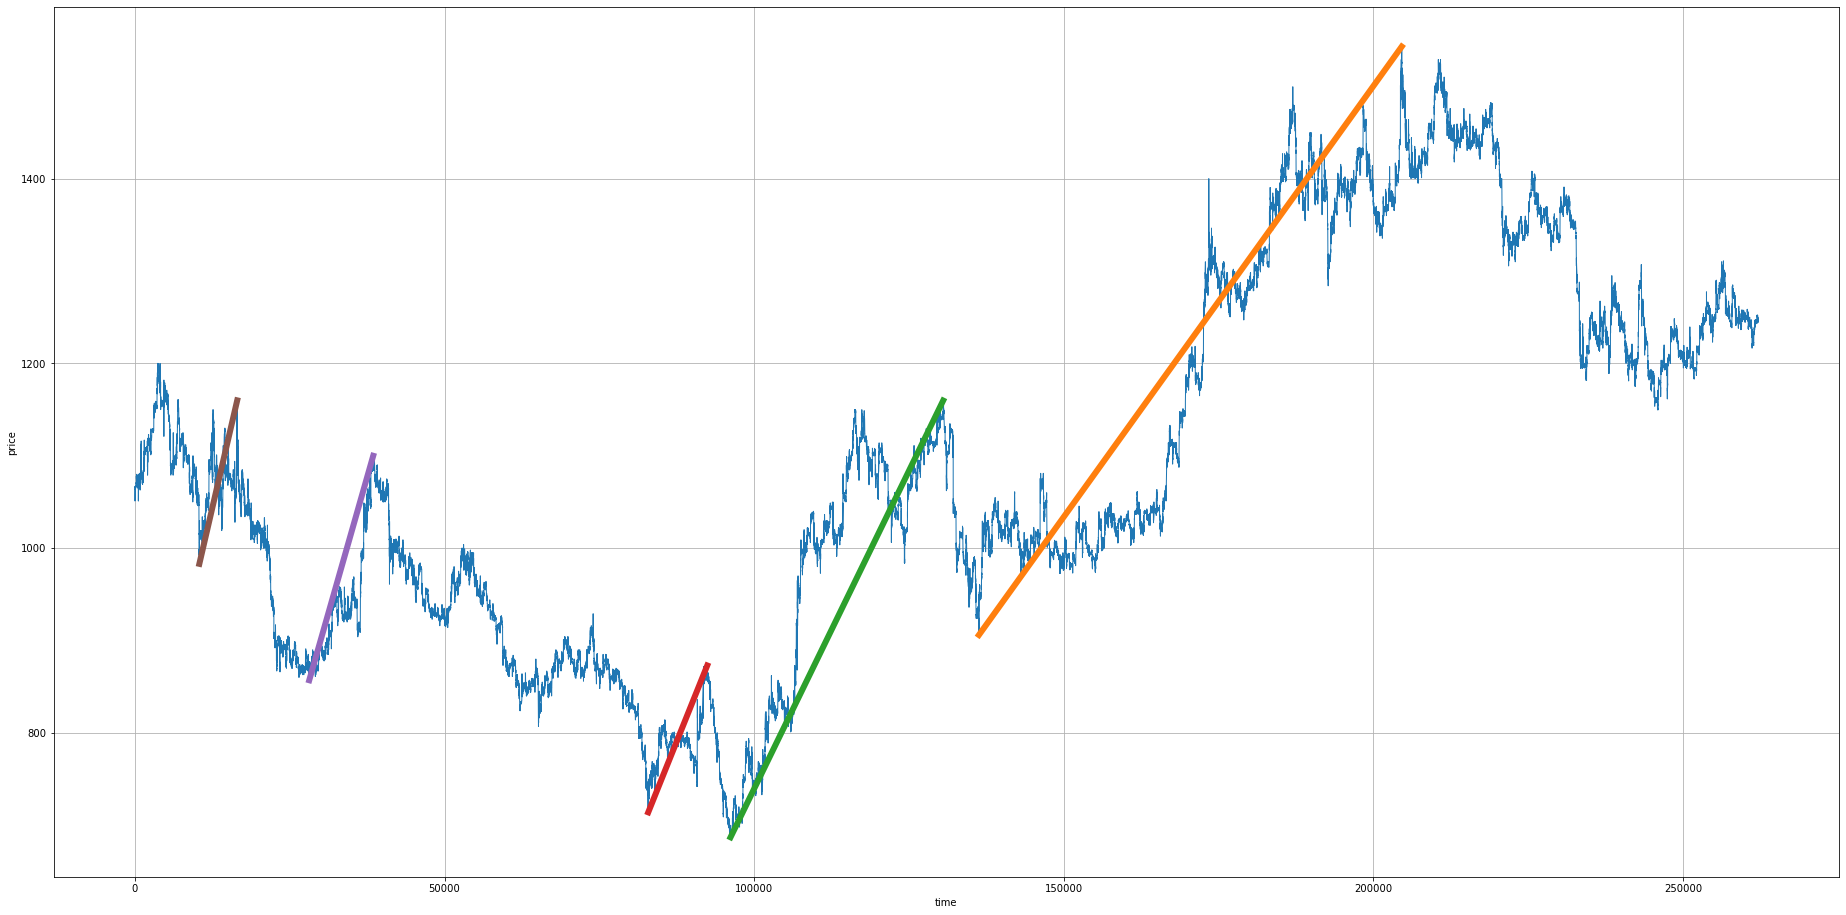

Позиция №  1  была открыта  20150202  в  183300  по цене  983.0  объемом  10.0
Позиция №  1  была закрыта  20150218  в  155700  по цене  1160.0
Баланс  11770.0
Позиция №  2  была открыта  20150324  в  181000  по цене  857.0  объемом  13.0
Позиция №  2  была закрыта  20150421  в  161800  по цене  1100.0
Баланс  14929.0
Позиция №  3  была открыта  20150824  в  163900  по цене  714.0  объемом  20.0
Позиция №  3  была закрыта  20150918  в  100100  по цене  873.0
Баланс  18109.0
Позиция №  4  была открыта  20150929  в  113500  по цене  687.0  объемом  26.0
Позиция №  4  была закрыта  20151230  в  175300  по цене  1159.8
Баланс  30401.80000000005
Позиция №  5  была открыта  20160120  в  181400  по цене  906.0  объемом  33.0
Позиция №  5  была закрыта  20160728  в  163400  по цене  1543.0
Баланс  51422.79999999996


In [12]:
model = Investments(data, 5, 10000) # 5 транзакций, депозит 10000
model.fit()
model.show()
model.getInfo()

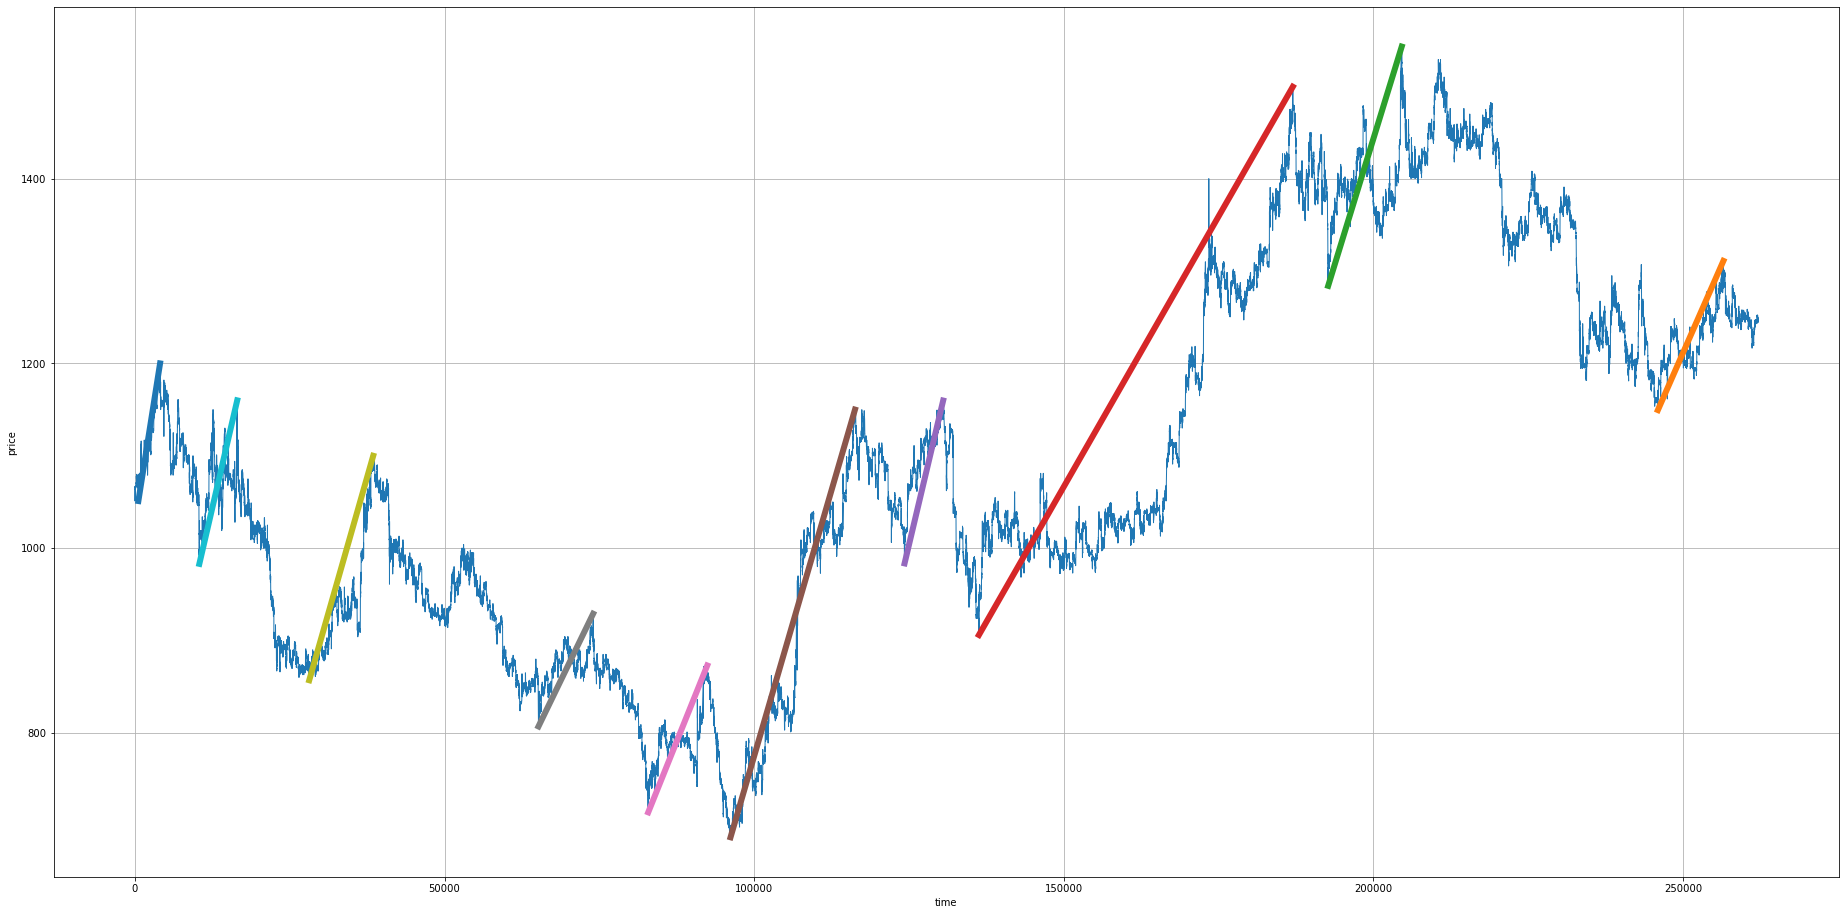

Позиция №  1  была открыта  20150106  в  104700  по цене  1051.0  объемом  9.0
Позиция №  1  была закрыта  20150115  в  170900  по цене  1200.0
Баланс  11341.0
Позиция №  2  была открыта  20150202  в  183300  по цене  983.0  объемом  11.0
Позиция №  2  была закрыта  20150218  в  155700  по цене  1160.0
Баланс  13288.0
Позиция №  3  была открыта  20150324  в  181000  по цене  857.0  объемом  15.0
Позиция №  3  была закрыта  20150421  в  161800  по цене  1100.0
Баланс  16933.0
Позиция №  4  была открыта  20150707  в  172400  по цене  807.0  объемом  20.0
Позиция №  4  была закрыта  20150730  в  163200  по цене  929.0
Баланс  19373.0
Позиция №  5  была открыта  20150824  в  163900  по цене  714.0  объемом  27.0
Позиция №  5  была закрыта  20150918  в  100100  по цене  873.0
Баланс  23666.0
Позиция №  6  была открыта  20150929  в  113500  по цене  687.0  объемом  34.0
Позиция №  6  была закрыта  20151123  в  152900  по цене  1150.0
Баланс  39407.999999999774
Позиция №  7  была открыта  201

In [13]:
model = Investments(data, 10, 10000) # 10 транзакций, депозит 10000
model.fit()
model.show()
model.getInfo()

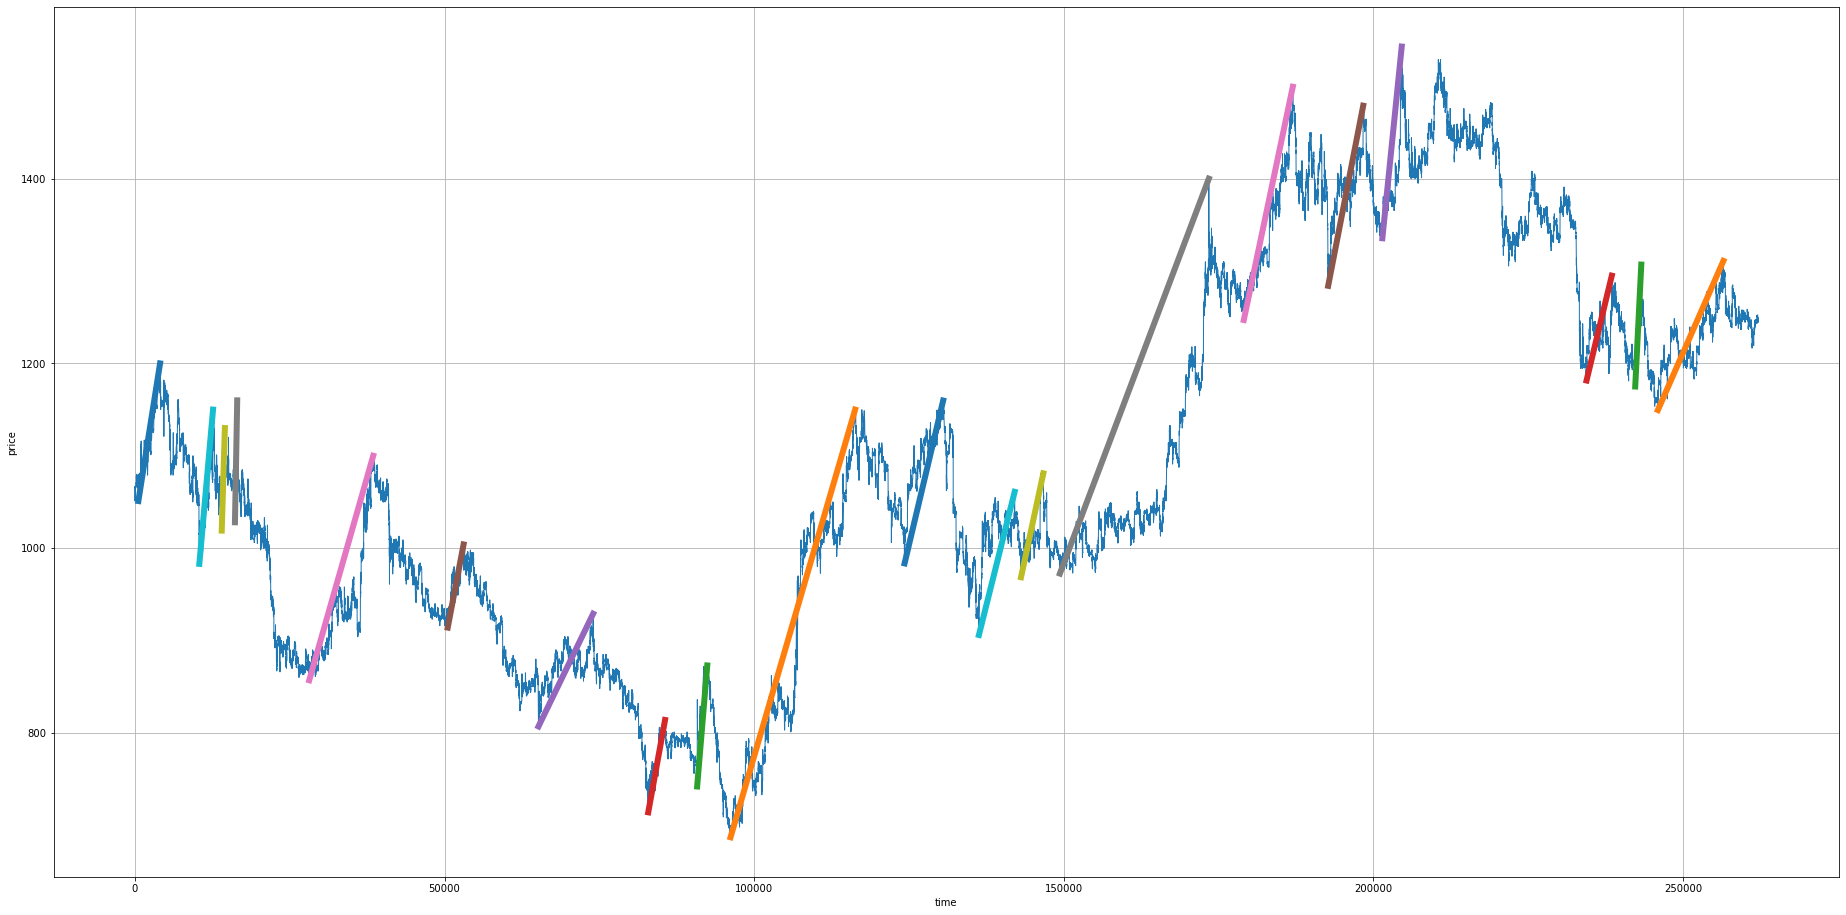

Позиция №  1  была открыта  20150106  в  104700  по цене  1051.0  объемом  9.0
Позиция №  1  была закрыта  20150115  в  170900  по цене  1200.0
Баланс  11341.0
Позиция №  2  была открыта  20150202  в  183300  по цене  983.0  объемом  11.0
Позиция №  2  была закрыта  20150209  в  115200  по цене  1150.0
Баланс  13178.0
Позиция №  3  была открыта  20150211  в  174700  по цене  1019.0  объемом  12.0
Позиция №  3  была закрыта  20150212  в  173200  по цене  1130.0
Баланс  14510.0
Позиция №  4  была открыта  20150217  в  183500  по цене  1028.0  объемом  14.0
Позиция №  4  была закрыта  20150218  в  155700  по цене  1160.0
Баланс  16358.0
Позиция №  5  была открыта  20150324  в  181000  по цене  857.0  объемом  19.0
Позиция №  5  была закрыта  20150421  в  161800  по цене  1100.0
Баланс  20975.0
Позиция №  6  была открыта  20150527  в  165000  по цене  914.0  объемом  22.0
Позиция №  6  была закрыта  20150603  в  160100  по цене  1004.0
Баланс  22955.0
Позиция №  7  была открыта  20150707  

In [14]:
model = Investments(data, 20, 10000) # 20 транзакций, депозит 10000
model.fit()
model.show("chart_YDX_20.jpg")
model.getInfo()